In [5]:
import pandas as pd


df = pd.read_csv('../raw_data/mpst_full_data.csv')


df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


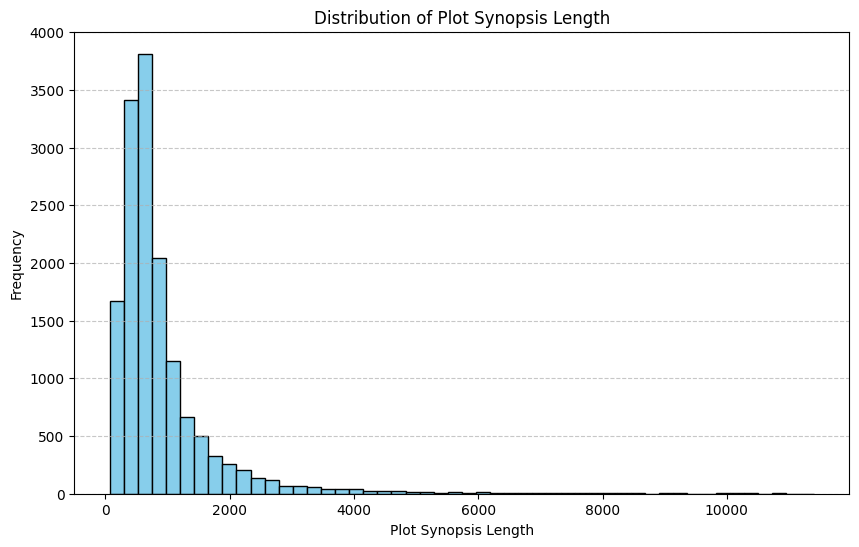

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['plot_synopsis'].apply(lambda x: len(x.split())), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Plot Synopsis Length')
plt.xlabel('Plot Synopsis Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:
# Lower case
df['plot_synopsis'] = df['plot_synopsis'].apply(lambda x: x.lower())

In [8]:
# Remove punctuation and numbers
import re
df['plot_synopsis'] = df['plot_synopsis'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [9]:
# Tokenize text
from nltk.tokenize import word_tokenize
df['plot_synopsis'] = df['plot_synopsis'].apply(lambda x: word_tokenize(x))

In [10]:
# Remove  Stopwords
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
df['plot_synopsis'] = df['plot_synopsis'].apply(lambda x: [w for w in x if not w in stop_words])

In [11]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['plot_synopsis'] = df['plot_synopsis'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

In [12]:
# Drop dupes
df = df.drop_duplicates(subset=['title'])

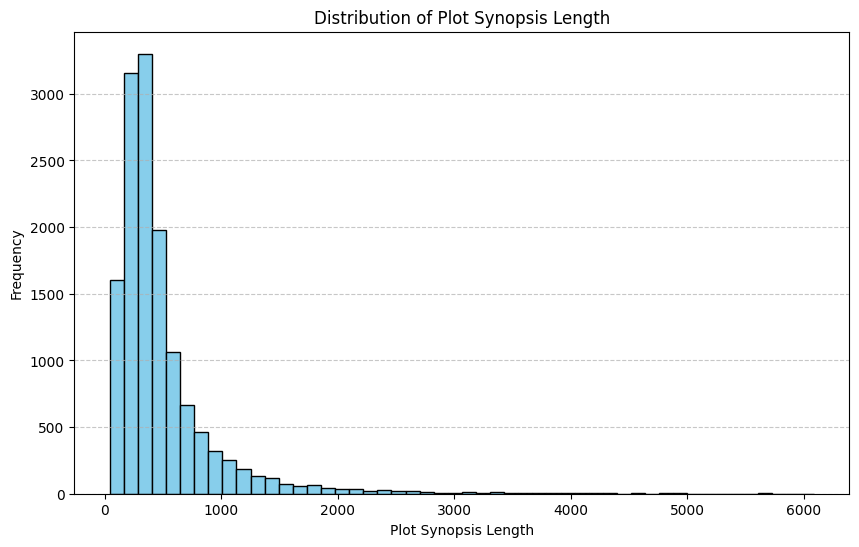

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['plot_synopsis'].apply(len), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Plot Synopsis Length')
plt.xlabel('Plot Synopsis Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [15]:
# DF with tags added to plot
df['plot_synopsis_str'] = df['plot_synopsis'].apply(lambda x: ' '.join(map(str, x)))
df_combined = pd.DataFrame({'title': df['title'],
    'combined_synopsis': df['plot_synopsis_str'] + ' ' + df['tags']
})

In [16]:
df_combined['plot_word_count'] = df_combined['combined_synopsis'].apply(lambda x: len(x.split(' ')))
df_2000 = df_combined[df_combined['plot_word_count'] < 2000].copy()
df_2000 = df_2000.drop(columns = 'plot_word_count', axis = 1)

In [140]:
len(df_2000)

13497

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df_2000['combined_synopsis'])

In [18]:
def find_recommendation(text):
    user_tf_idf_vector = tf_idf_vectorizer.transform([text])
    cos_similarities = linear_kernel(user_tf_idf_vector, tf_idf_matrix).flatten()
    similar_movies = pd.DataFrame({'title': df_2000['title'], 'similarity': cos_similarities})
    similar_movies = similar_movies.sort_values(by='similarity', ascending=False)
    recommendations = f"Top 5 recommendations {similar_movies.head(10)['title'].tolist()}"
    return similar_movies.head(10)

In [19]:
print(find_recommendation('film about a drug addict trying to get his life back'))

                          title  similarity
7132            The Last Minute    0.177206
927            Drugstore Cowboy    0.164517
1680   The Panic in Needle Park    0.161751
9925            Cocaine Cowboys    0.155862
11575               Little Fish    0.154496
11667        Permanent Midnight    0.152283
5503                    Traffic    0.138820
6998   Number One with a Bullet    0.136275
11755            Out for a Kill    0.132315
1064             The Good Thief    0.123819


In [20]:
df['plot_word_count'] = df['plot_synopsis'].apply(lambda x: len(x))
df_2000_new = df[df['plot_word_count'] < 2000].copy()
df_2000_new = df_2000_new.drop(columns = 'plot_word_count', axis = 1)

In [21]:
tf_idf_vectorizer_new = TfidfVectorizer(stop_words='english')
tf_idf_matrix_new = tf_idf_vectorizer_new.fit_transform(df_2000_new['plot_synopsis_str'])

In [22]:
def find_recommendation_new(text):
    user_tf_idf_vector = tf_idf_vectorizer_new.transform([text])
    cos_similarities = linear_kernel(user_tf_idf_vector, tf_idf_matrix_new).flatten()
    similar_movies = pd.DataFrame({'title': df_2000_new['title'], 'similarity': cos_similarities})
    similar_movies = similar_movies.sort_values(by='similarity', ascending=False)
    recommendations = f"Top 5 recommendations {similar_movies.head(10)['title'].tolist()}"
    return similar_movies.head(10)

In [23]:
print(find_recommendation_new('film about a drug addict trying to get his life back'))

                          title  similarity
7132            The Last Minute    0.177485
927            Drugstore Cowboy    0.164543
1680   The Panic in Needle Park    0.161674
9925            Cocaine Cowboys    0.156181
11575               Little Fish    0.155184
11667        Permanent Midnight    0.152150
5503                    Traffic    0.138874
6998   Number One with a Bullet    0.136051
11755            Out for a Kill    0.132564
1064             The Good Thief    0.124301
